In [1]:
import sys
sys.path.insert(1, '../functions')
from gk import gk
from mwrko import mwrko
from gko import gko
from method import method
from method2 import method2
from compute_sin2 import compute_sin2
import math 

In [2]:
# importing necessary libraries
from time import process_time
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import random
import math
from scipy import sparse
from scipy.sparse import random
from scipy import stats
from numpy.random import default_rng
from sklearn.preprocessing import normalize
import numpy as np
import pandas as pd
from itertools import permutations

# Convergence Rate

#### GK

$$||x_k - x^*||^2 \leq \left ( 1 - \frac{\sigma^2_\min (A)}{m} \right) ^k ||x_0 - x^*||^2$$ or
$$||x_k - x^*||^2 \leq \Pi^{k-1}_{j = 0} \left ( 1 - \frac{\sigma^2_\min (A)}{\gamma_{k+1}} \right) ||x_0 - x^*||^2$$ where $\gamma_{k+1} = \frac{||Ax_{k+1}-b||^2}{||Ax_{k+1}-b||^2_{\infty}}$. In this experiment, we are using first convergence rate for GK.

#### GKO and MWRKO

For k = 1: $$||x_1 - x^*||^2 \leq \left ( 1 - \frac{\sigma^2_\min (A)}{m} \right) ||x_0 - x^*||^2$$

For k = 2: $$||x_2 - x^*||^2 \leq \left ( 1 - \frac{\sigma^2_\min (A)}{ ( \max_i \sin^2\theta_i )(m-1)} \right)||x_1 - x^*||^2$$

For k > 2:

**GKO:** $$||x_{k+1} - x^*||^2 \leq \left ( 1 - \frac{\sigma^2_\min (A)}{\max_i \sin^2\theta_i} \right)||x_k - x^*||^2$$

**MWRKO:** $$||x_2 - x^*||^2 \leq \left ( 1 - \frac{\sigma^2_\min (A)}{ ( \max_i \sin^2\theta_i )(m-2)} \right) ||x_k - x^*||^2$$

## Gaussian System

In [3]:
# setting up data
A = np.random.randn(5000,500)
A = normalize(A, axis=1, norm='l2')
m,n = A.shape
x = np.ones(500)
y = A @ x
TOL = 10**-4

In [4]:
# Find the minimum singular value
U,S,V = np.linalg.svd(A)
S2_min = min(S**2)
# Find the max angle
angles_g = compute_sin2(A)
max_angle_g = max(angles_g)
# Find the row norm
row_norm_g = np.sum(np.abs(A)**2,axis=-1)
max_row_norm_g = max(row_norm_g)

In [5]:
# Compute LH of convergence rate
# gk (LH1 = LH2 = 0)
LHk_gk = S2_min / 4
# gko
LH1_gko = 1 - ( S2_min / m )
#LH2_gko = S2_min / (max_angle_g * (m-1)) )
LHk_gko = S2_min / max_angle_g
# mwrko
LH1_mwrko = 1 - ( S2_min / m )
LH2_mwrko = 1- ( S2_min / (max_angle_g * (m-1)) )
LHk_mwrko =  1- ( S2_min / (max_angle_g * (m-2)) )

In [6]:
# Run algorithms
gk_gaussian = method2(A,x,y,'GK', 0, 0, LHk_gk, 0.5*10**-8)
gko_gaussian = method2(A,x,y,'GKO', LH1_gko, LHk_gko, LHk_gko, 0.5*10**-8)
mwrko_gaussian = method2(A,x,y,'MWRKO', LH1_mwrko, LH2_mwrko, LHk_mwrko,0.5*10**-8)

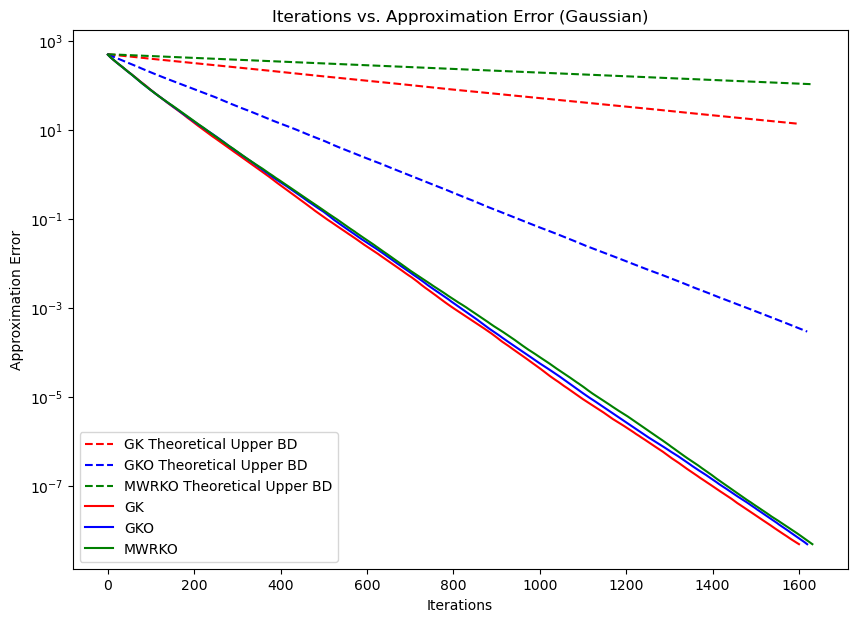

In [7]:
plt.figure(figsize=(10,7))
# plot theoretical bound
plt.semilogy(np.arange(len(gk_gaussian[2])), gk_gaussian[2], linestyle = 'dashed',
             color = "red", label = 'GK Theoretical Upper BD')
plt.semilogy(np.arange(len(gko_gaussian[2])), gko_gaussian[2], linestyle = 'dashed', 
            color = "blue", label = 'GKO Theoretical Upper BD')
plt.semilogy(np.arange(len(mwrko_gaussian[2])), mwrko_gaussian[2], linestyle = 'dashed', 
             color = "green", label = 'MWRKO Theoretical Upper BD')
# plot empirical results
plt.semilogy(np.arange(gk_gaussian[0] - 1), gk_gaussian[1], color = "red", linestyle = 'solid', label = 'GK')
plt.semilogy(np.arange(gko_gaussian[0] - 1), gko_gaussian[1], linestyle = 'solid', color = "blue", label = 'GKO')
plt.semilogy(np.arange(mwrko_gaussian[0] - 1), mwrko_gaussian[1], linestyle = 'solid', color = "green", label = 'MWRKO')
# labels
plt.xlabel('Iterations')
plt.ylabel('Approximation Error')
plt.title('Iterations vs. Approximation Error (Gaussian)')
plt.legend()

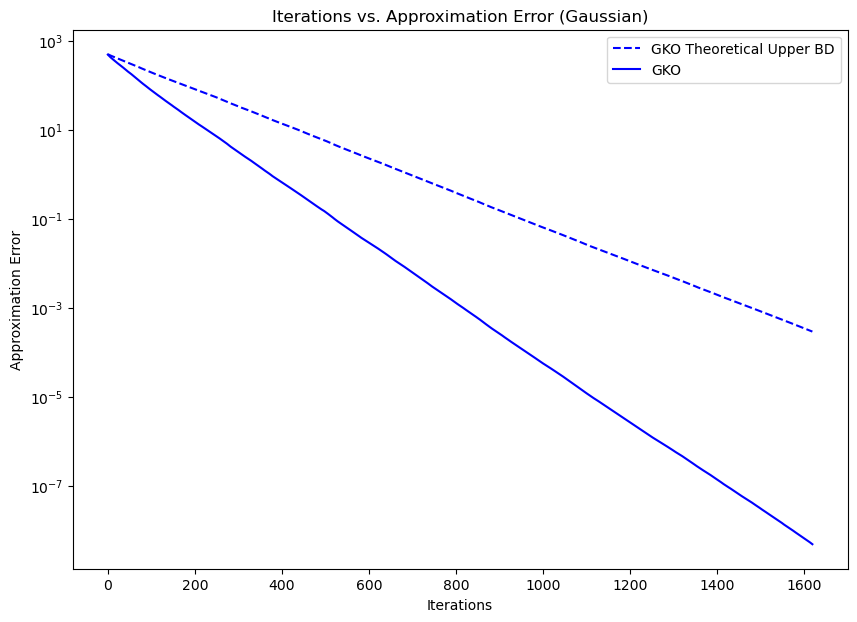

In [8]:
plt.figure(figsize=(10,7))
# plot theoretical bound
plt.semilogy(np.arange(len(gko_gaussian[2])), gko_gaussian[2], linestyle = 'dashed', 
            color = "blue", label = 'GKO Theoretical Upper BD')
plt.semilogy(np.arange(gko_gaussian[0] - 1), gko_gaussian[1], linestyle = 'solid', 
             color = "blue", label = 'GKO')

# labels
plt.xlabel('Iterations')
plt.ylabel('Approximation Error')
plt.title('Iterations vs. Approximation Error (Gaussian)')
plt.legend()

In [9]:
i=0
for n in range(gko_gaussian[0]):
    if gko_gaussian[2] > gko_gaussian[1]:
        i+=1

gko_gaussian[0] == i

True

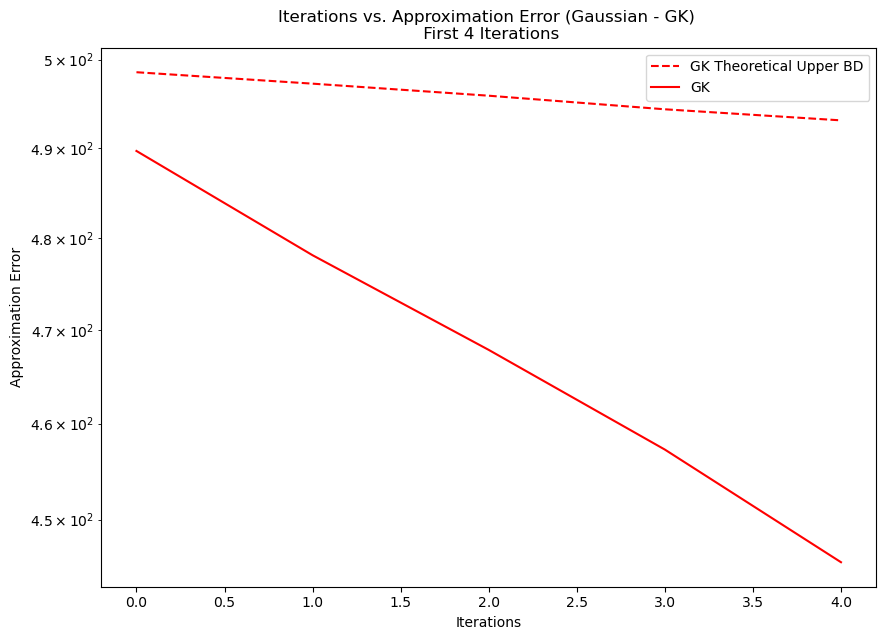

In [10]:
# Show GK empirical and theoretical results
plt.figure(figsize=(10,7))
# plot theoretical bound
plt.semilogy(np.arange(5), gk_gaussian[2][0:5], linestyle = 'dashed', 
             color = "red", label = 'GK Theoretical Upper BD')
# plot empirical results
plt.semilogy(np.arange(5), gk_gaussian[1][0:5], linestyle = 'solid', 
             color = "red", label = 'GK')
# labels
plt.xlabel('Iterations')
plt.ylabel('Approximation Error')
plt.title('Iterations vs. Approximation Error (Gaussian - GK) \n First 4 Iterations')
plt.legend()

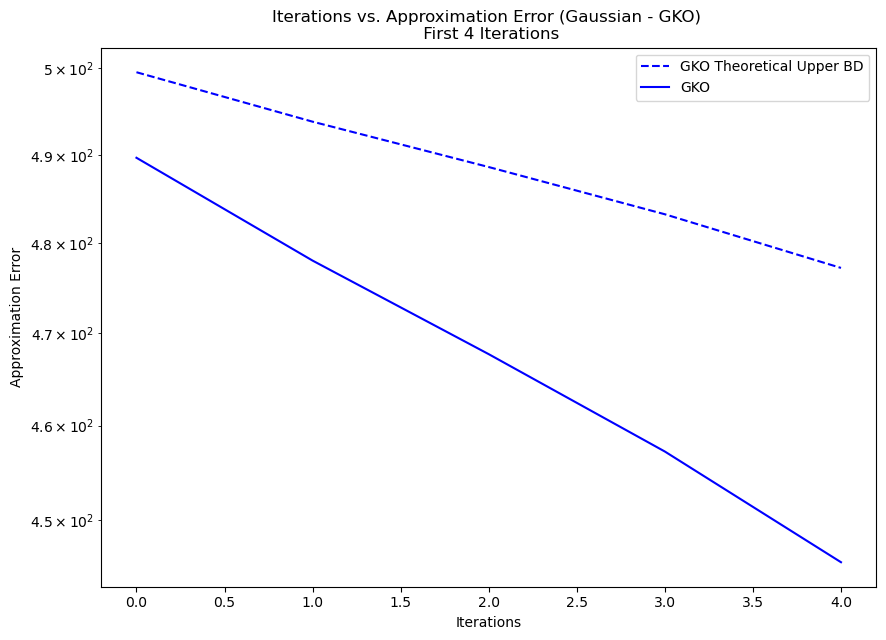

In [11]:
# Show GKO empirical and theoretical results
plt.figure(figsize=(10,7))
# plot theoretical bound
plt.semilogy(np.arange(5), gko_gaussian[2][0:5], linestyle = 'dashed', 
             color = "blue", label = 'GKO Theoretical Upper BD')
# plot empirical results
plt.semilogy(np.arange(5), gko_gaussian[1][0:5], linestyle = 'solid', 
             color = "blue", label = 'GKO')
# labels
plt.xlabel('Iterations')
plt.ylabel('Approximation Error')
plt.title('Iterations vs. Approximation Error (Gaussian - GKO) \n First 4 Iterations')
plt.legend()

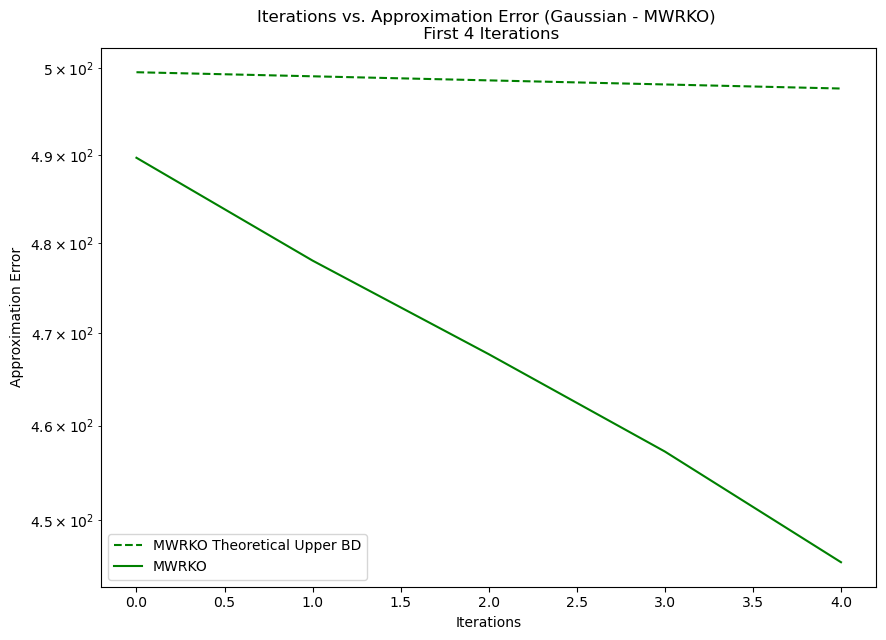

In [12]:
# Show MWRKO empirical and theoretical results
plt.figure(figsize=(10,7))
# plot theoretical bound
plt.semilogy(np.arange(5), mwrko_gaussian[2][0:5], linestyle = 'dashed', 
             color = "green", label = 'MWRKO Theoretical Upper BD')
# plot empirical results
plt.semilogy(np.arange(5), mwrko_gaussian[1][0:5], linestyle = 'solid', 
             color = "green", label = 'MWRKO')
# labels
plt.xlabel('Iterations')
plt.ylabel('Approximation Error')
plt.title('Iterations vs. Approximation Error (Gaussian - MWRKO) \n First 4 Iterations')
plt.legend()

In [13]:
# table
k = list(range(1,11))
k.extend(list(range((mwrko_gaussian[0]-9), mwrko_gaussian[0]+1)))
# empirical result data
e_result = list(mwrko_gaussian[1][0:10])
e_result.extend(list(mwrko_gaussian[1][-11:-1]))
# theoretical result data
t_result = list(mwrko_gaussian[2][0:10])
t_result.extend(list(mwrko_gaussian[2][-11:-1]))
# create and print df
mwrko_gauss_df = pd.DataFrame()
mwrko_gauss_df['k'] = k
mwrko_gauss_df['Theoretical BD'] = t_result
mwrko_gauss_df['Empirical Results'] = e_result
mwrko_gauss_df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
k,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000,1.624000e+03,1.625000e+03,1.626000e+03,1.627000e+03,1.628000e+03,1.629000e+03,1.630000e+03,1.631000e+03,1.632000e+03,1.633000e+03
Theoretical BD,499.524932,499.050220,498.575865,498.101960,497.628506,497.155502,496.682947,496.210842,495.739185,495.267977,1.069261e+02,1.068244e+02,1.067229e+02,1.066215e+02,1.065201e+02,1.064189e+02,1.063177e+02,1.062167e+02,1.061157e+02,1.060148e+02
Empirical Results,489.653582,478.046339,467.724370,457.218506,445.562132,436.353504,427.546589,418.939759,411.124843,403.596017,5.807759e-09,5.721934e-09,5.628017e-09,5.541422e-09,5.444396e-09,5.359554e-09,5.281203e-09,5.203675e-09,5.121928e-09,5.028769e-09


## Uniform System

In [51]:
# setting up data
A = np.random.uniform(size =(5000,500), low = 0, high = 1)
A = normalize(A, axis=1, norm='l2')
x = np.ones(500)
y = A @ x
TOL = 10**-4

In [52]:
# Find the minimum singular value
U,S,V = np.linalg.svd(A)
S2_min = min(S**2)
# Find the max angle
angles_g = compute_sin2(A)
max_angle_g = max(angles_g)
# Find the row norm
row_norm_g = np.sum(np.abs(A)**2,axis=-1)
max_row_norm_g = max(row_norm_g)

In [53]:
# Compute LH of convergence rate
# gk (LH1 = LH2 = 0)
LHk_gk =  S2_min / 4
# gko
LH1_gko = 1 - ( S2_min / m )
#LH2_gko = S2_min / (max_angle_g * (m-1)) )
LHk_gko = S2_min / max_angle_g 
# mwrko
LH1_mwrko = 1 - ( S2_min / m )
LH2_mwrko = 1- ( S2_min / (max_angle_g * (m-1)) )
LHk_mwrko =  1- ( S2_min / (max_angle_g * (m-2)) )

In [54]:
# Run algorithms
gk_uniform = method2(A,x,y,'GK', 0, 0, LHk_gk, 0.5*10**-8)
gko_uniform = method2(A,x,y,'GKO', LH1_gko, LHk_gko, LHk_gko, 0.5*10**-8)
mwrko_uniform = method2(A,x,y,'MWRKO', LH1_mwrko, LH2_mwrko, LHk_mwrko,0.5*10**-8)

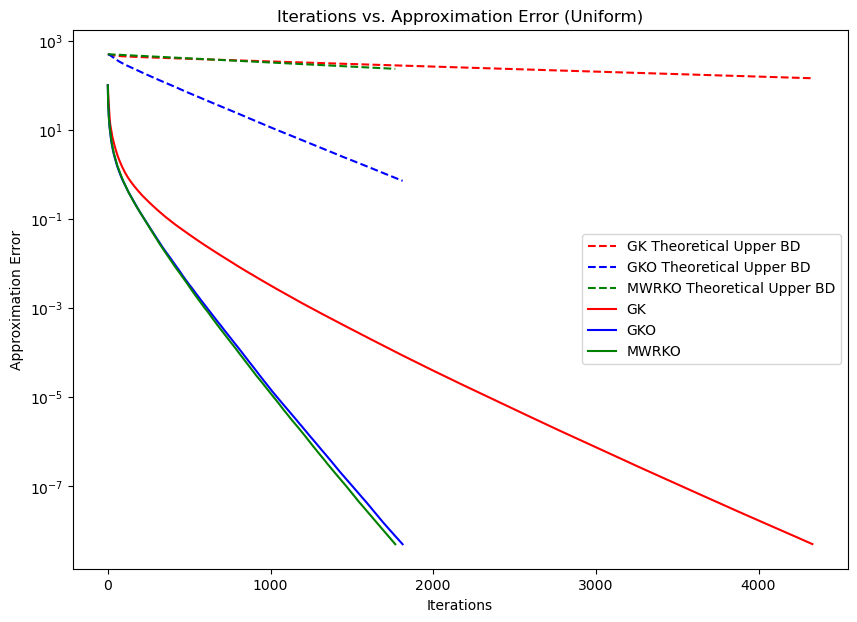

In [55]:
plt.figure(figsize=(10,7))
# plot theoretical bound
plt.semilogy(np.arange(len(gk_uniform[2])), gk_uniform[2], linestyle = 'dashed',
             color = "red", label = 'GK Theoretical Upper BD')
plt.semilogy(np.arange(len(gko_uniform[2])), gko_uniform[2], linestyle = 'dashed', 
             color = "blue", label = 'GKO Theoretical Upper BD')
plt.semilogy(np.arange(len(mwrko_uniform[2])), mwrko_uniform[2], linestyle = 'dashed', 
             color = "green", label = 'MWRKO Theoretical Upper BD')
# plot empirical results
plt.semilogy(np.arange(gk_uniform[0] - 1), gk_uniform[1], 
             color = "red", linestyle = 'solid', label = 'GK')
plt.semilogy(np.arange(gko_uniform[0] - 1), gko_uniform[1], linestyle = 'solid', 
             color = "blue", label = 'GKO')
plt.semilogy(np.arange(mwrko_uniform[0] - 1), mwrko_uniform[1], linestyle = 'solid', 
             color = "green", label = 'MWRKO')
# labels
plt.xlabel('Iterations')
plt.ylabel('Approximation Error')
plt.title('Iterations vs. Approximation Error (Uniform)')
plt.legend()

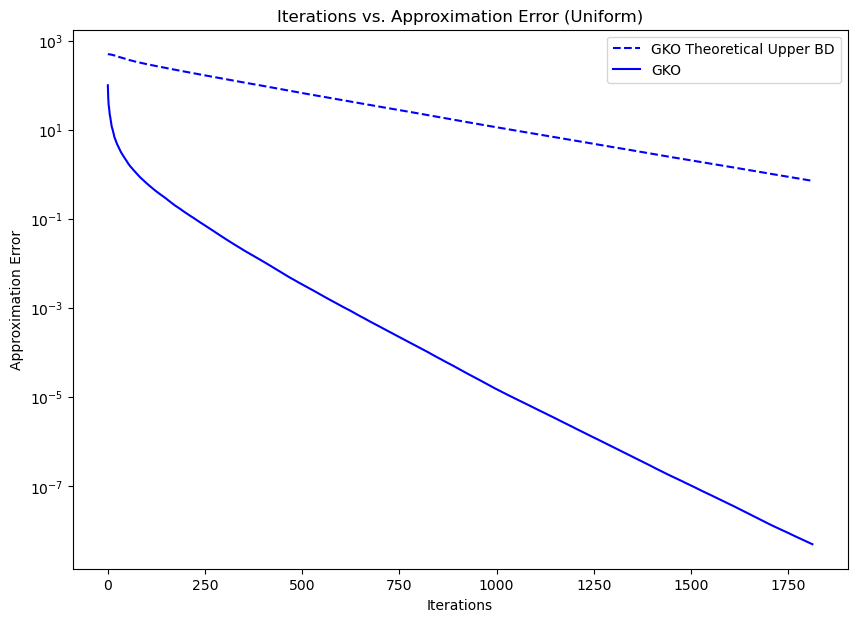

In [56]:
plt.figure(figsize=(10,7))
# plot theoretical bound
plt.semilogy(np.arange(len(gko_uniform[2])), gko_uniform[2], linestyle = 'dashed', 
             color = "blue", label = 'GKO Theoretical Upper BD')
plt.semilogy(np.arange(gko_uniform[0] - 1), gko_uniform[1], linestyle = 'solid', 
             color = "blue", label = 'GKO')

plt.xlabel('Iterations')
plt.ylabel('Approximation Error')
plt.title('Iterations vs. Approximation Error (Uniform)')
plt.legend()

In [57]:
i=0
for n in range(gko_uniform[0]):
    if gko_uniform[2] > gko_uniform[1]:
        i+=1

gko_uniform[0] == i

True

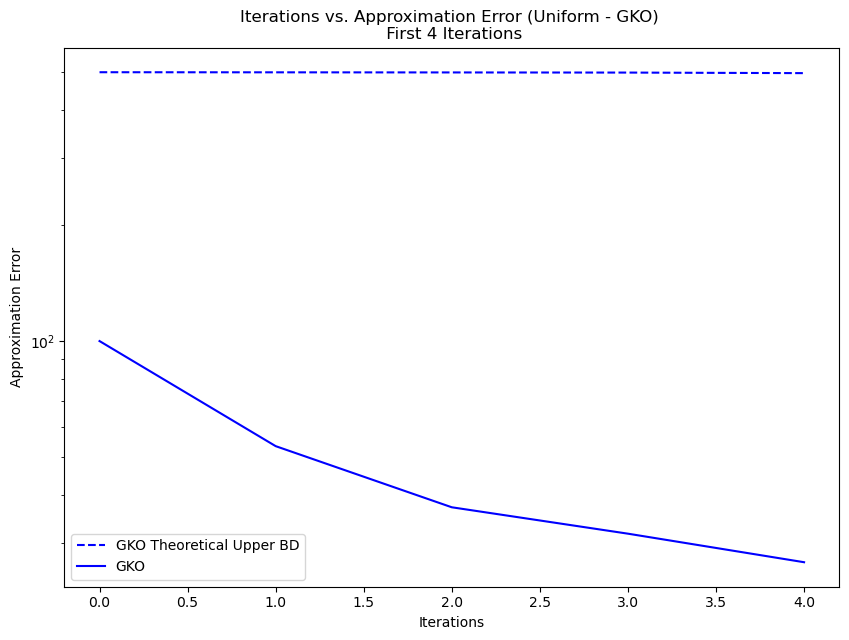

In [58]:
# Show MWRKO empirical and theoretical results
plt.figure(figsize=(10,7))
# plot theoretical bound
plt.semilogy(np.arange(5), gko_uniform[2][0:5], linestyle = 'dashed', 
             color = "blue", label = 'GKO Theoretical Upper BD')
# plot empirical results
plt.semilogy(np.arange(5), gko_uniform[1][0:5], linestyle = 'solid', 
             color = "blue", label = 'GKO')
# labels
plt.xlabel('Iterations')
plt.ylabel('Approximation Error')
plt.title('Iterations vs. Approximation Error (Uniform - GKO) \n First 4 Iterations')
plt.legend()

In [59]:
# table
k = list(range(1,11))
k.extend(list(range((mwrko_uniform[0]-9), mwrko_uniform[0]+1)))
# empirical result data
e_result = list(mwrko_uniform[1][0:10])
e_result.extend(list(mwrko_uniform[1][-11:-1]))
# theoretical result data
t_result = list(mwrko_uniform[2][0:10])
t_result.extend(list(mwrko_uniform[2][-11:-1]))
# create and print df
mwrko_uniform_df = pd.DataFrame()
mwrko_uniform_df['k'] = k
mwrko_uniform_df['Theoretical BD'] = t_result
mwrko_uniform_df['Empirical Results'] = e_result
mwrko_uniform_df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
k,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000,1.760000e+03,1.761000e+03,1.762000e+03,1.763000e+03,1.764000e+03,1.765000e+03,1.766000e+03,1.767000e+03,1.768000e+03,1.769000e+03
Theoretical BD,499.882147,499.668373,499.454649,499.241015,499.027473,498.814022,498.600662,498.387394,498.174217,497.961131,2.357292e+02,2.356284e+02,2.355276e+02,2.354268e+02,2.353261e+02,2.352255e+02,2.351249e+02,2.350243e+02,2.349238e+02,2.348233e+02
Empirical Results,100.164401,53.675166,38.329426,32.726533,26.659647,21.263721,19.001673,17.243577,15.342337,13.935370,5.452728e-09,5.396831e-09,5.346538e-09,5.299816e-09,5.249951e-09,5.202143e-09,5.152885e-09,5.097919e-09,5.050174e-09,5.004997e-09


## 50/50 Gauss-Uniform System

In [60]:
# setting up data
A1 = np.random.rand(2500,500)
A2 = np.random.randn(2500,500)
A = np.concatenate((A1, A2))
A = normalize(A, axis=1, norm='l2')
x = np.ones(500)
y = A @ x
TOL = 10**-4

In [61]:
# Find the minimum singular value
U,S,V = np.linalg.svd(A)
S2_min = min(S**2)
# Find the max angle
angles_g = compute_sin2(A)
max_angle_g = max(angles_g)
# Find the row norm
row_norm_g = np.sum(np.abs(A)**2,axis=-1)
max_row_norm_g = max(row_norm_g)

In [62]:
# Compute LH of convergence rate
# gk (LH1 = LH2 = 0)
LHk_gk = S2_min / 4
# gko
LH1_gko = 1 - ( S2_min / m )
#LH2_gko = S2_min / (max_angle_g * (m-1)) )
LHk_gko = S2_min / max_angle_g 
# mwrko
LH1_mwrko = 1 - ( S2_min / m )
LH2_mwrko = 1- ( S2_min / (max_angle_g * (m-1)) )
LHk_mwrko =  1- ( S2_min / (max_angle_g * (m-2)) )

In [63]:
# Run algorithms
gk_gu1 = method2(A,x,y,'GK', 0, 0, LHk_gk, 0.5*10**-8)
gko_gu1 = method2(A,x,y,'GKO', LH1_gko, LHk_gko, LHk_gko, 0.5*10**-8)
mwrko_gu1 = method2(A,x,y,'MWRKO', LH1_mwrko, LH2_mwrko, LHk_mwrko,0.5*10**-8)

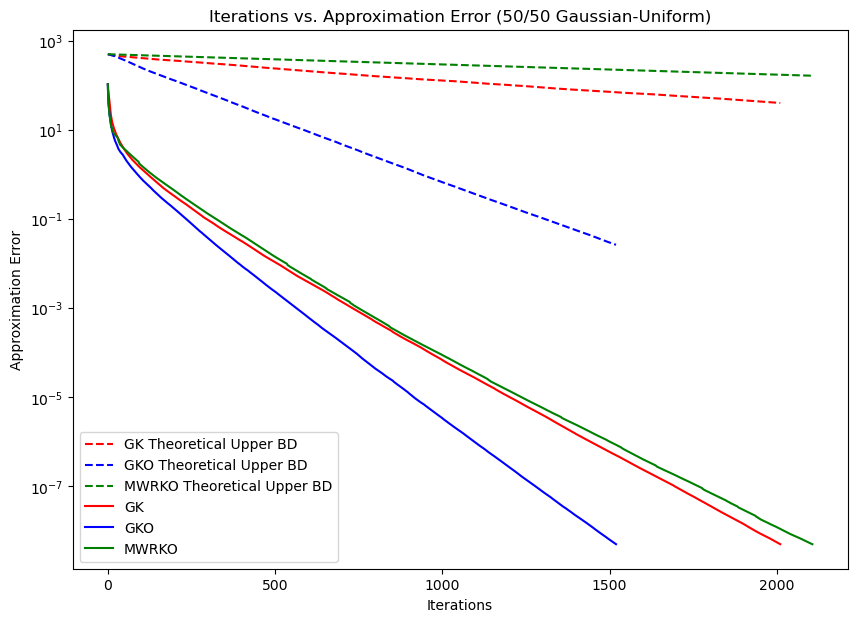

In [64]:
# plot the results with the theoretical upper bound
plt.figure(figsize=(10,7))
# plot theoretical bound
plt.semilogy(np.arange(len(gk_gu1[2])), gk_gu1[2], linestyle = 'dashed',
             color = "red", label = 'GK Theoretical Upper BD')
plt.semilogy(np.arange(len(gko_gu1[2])), gko_gu1[2], linestyle = 'dashed', 
             color = "blue", label = 'GKO Theoretical Upper BD')
plt.semilogy(np.arange(len(mwrko_gu1[2])), mwrko_gu1[2], linestyle = 'dashed', 
             color = "green", label = 'MWRKO Theoretical Upper BD')
# plot empirical results
plt.semilogy(np.arange(gk_gu1[0] - 1), gk_gu1[1], 
             color = "red", linestyle = 'solid', label = 'GK')
plt.semilogy(np.arange(gko_gu1[0] - 1), gko_gu1[1], linestyle = 'solid', 
             color = "blue", label = 'GKO')
plt.semilogy(np.arange(mwrko_gu1[0] - 1), mwrko_gu1[1], linestyle = 'solid', 
             color = "green", label = 'MWRKO')
plt.xlabel('Iterations')
plt.ylabel('Approximation Error')
plt.title('Iterations vs. Approximation Error (50/50 Gaussian-Uniform)')
plt.legend()

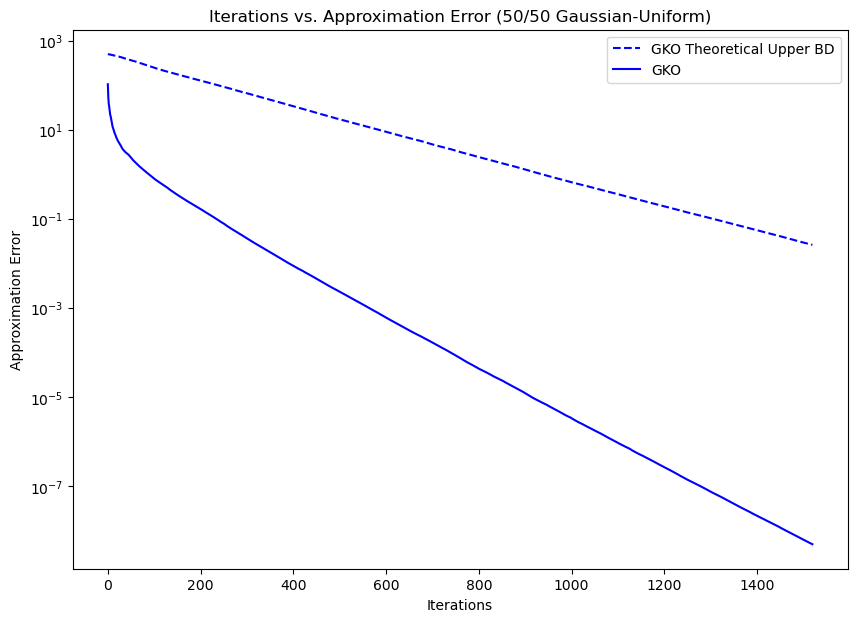

In [65]:
# plot the results with the theoretical upper bound
plt.figure(figsize=(10,7))
# plot theoretical bound
plt.semilogy(np.arange(len(gko_gu1[2])), gko_gu1[2], linestyle = 'dashed', 
             color = "blue", label = 'GKO Theoretical Upper BD')
plt.semilogy(np.arange(gko_gu1[0] - 1), gko_gu1[1], linestyle = 'solid', 
             color = "blue", label = 'GKO')

plt.xlabel('Iterations')
plt.ylabel('Approximation Error')
plt.title('Iterations vs. Approximation Error (50/50 Gaussian-Uniform)')
plt.legend()

In [66]:
i=0
for n in range(gko_gu1[0]):
    if gko_gu1[2] > gko_gu1[1]:
        i+=1

gko_gu1[0] == i

True

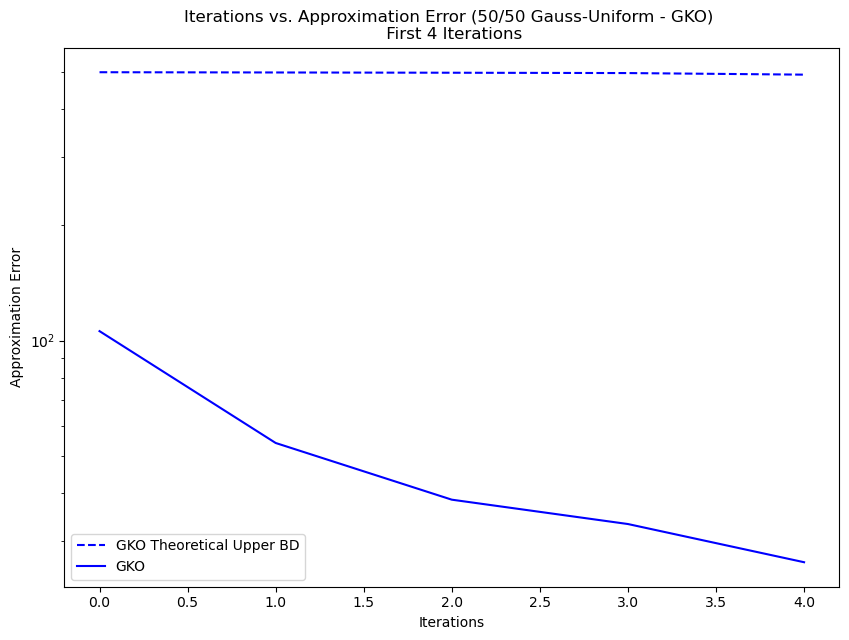

In [67]:
# Show MWRKO empirical and theoretical results
plt.figure(figsize=(10,7))
# plot theoretical bound
plt.semilogy(np.arange(5), gko_gu1[2][0:5], linestyle = 'dashed', 
             color = "blue", label = 'GKO Theoretical Upper BD')
# plot empirical results
plt.semilogy(np.arange(5), mwrko_gu1[1][0:5], linestyle = 'solid', 
             color = "blue", label = 'GKO')
# labels
plt.xlabel('Iterations')
plt.ylabel('Approximation Error')
plt.title('Iterations vs. Approximation Error (50/50 Gauss-Uniform - GKO) \n First 4 Iterations')
plt.legend()

In [68]:
# table
k = list(range(1,11))
k.extend(list(range((mwrko_gu1[0]-9), mwrko_gu1[0]+1)))
# empirical result data
e_result = list(mwrko_gu1[1][0:10])
e_result.extend(list(mwrko_gu1[1][-11:-1]))
# theoretical result data
t_result = list(mwrko_gu1[2][0:10])
t_result.extend(list(mwrko_gu1[2][-11:-1]))
# create and print df
mwrko_gu1_df = pd.DataFrame()
mwrko_gu1_df['k'] = k
mwrko_gu1_df['Theoretical BD'] = t_result
mwrko_gu1_df['Empirical Results'] = e_result
mwrko_gu1_df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
k,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000,2.099000e+03,2.100000e+03,2.101000e+03,2.102000e+03,2.103000e+03,2.104000e+03,2.105000e+03,2.106000e+03,2.107000e+03,2.108000e+03
Theoretical BD,499.736343,499.472773,499.209289,498.945945,498.682739,498.419671,498.156743,497.893953,497.631302,497.368790,1.653557e+02,1.652684e+02,1.651812e+02,1.650941e+02,1.650070e+02,1.649200e+02,1.648330e+02,1.647460e+02,1.646591e+02,1.645723e+02
Empirical Results,105.844038,54.140364,38.541086,33.305895,26.491492,20.875024,19.302358,17.002428,14.831108,13.302839,5.394450e-09,5.349809e-09,5.306134e-09,5.265463e-09,5.226482e-09,5.185941e-09,5.147402e-09,5.106982e-09,5.064722e-09,5.024747e-09


## 75/25 Gauss-Uniform System

In [69]:
# setting up data
A1 = np.random.rand(1250,500)
A2 = np.random.randn(3750,500)
A = np.concatenate((A1, A2))
A = normalize(A, axis=1, norm='l2')
x = np.ones(500)
y = A @ x
TOL = 10**-4

In [70]:
# Find the minimum singular value
U,S,V = np.linalg.svd(A)
S2_min = min(S**2)
# Find the max angle
angles_g = compute_sin2(A)
max_angle_g = max(angles_g)
# Find the row norm
row_norm_g = np.sum(np.abs(A)**2,axis=-1)
max_row_norm_g = max(row_norm_g)

In [71]:
# Compute LH of convergence rate
# gk (LH1 = LH2 = 0)
LHk_gk = S2_min / 4
# gko
LH1_gko = 1 - ( S2_min / m )
#LH2_gko = S2_min / (max_angle_g * (m-1)) )
LHk_gko = S2_min / max_angle_g 
# mwrko
LH1_mwrko = 1 - ( S2_min / m )
LH2_mwrko = 1- ( S2_min / (max_angle_g * (m-1)) )
LHk_mwrko =  1- ( S2_min / (max_angle_g * (m-2)) )

In [72]:
# Run algorithms
gk_gu2 = method2(A,x,y,'GK', 0, 0, LHk_gk, 0.5*10**-8)
gko_gu2 = method2(A,x,y,'GKO', LH1_gko, LHk_gko, LHk_gko, 0.5*10**-8)
mwrko_gu2 = method2(A,x,y,'MWRKO', LH1_mwrko, LH2_mwrko, LHk_mwrko,0.5*10**-8)

In [ ]:
# plot the results with the theoretical upper bound
plt.figure(figsize=(10,7))
# plot theoretical bound
plt.semilogy(np.arange(len(gk_gu2[2])), gk_gu2[2], linestyle = 'dashed',
             color = "red", label = 'GK Theoretical Upper BD')
plt.semilogy(np.arange(len(gko_gu2[2])), gko_gu2[2], linestyle = 'dashed', 
             color = "blue", label = 'GKO Theoretical Upper BD')
plt.semilogy(np.arange(len(mwrko_gu2[2])), mwrko_gu2[2], linestyle = 'dashed', 
             color = "green", label = 'MWRKO Theoretical Upper BD')
# plot empirical results
plt.semilogy(np.arange(gk_gu2[0] - 1), gk_gu2[1], 
             color = "red", linestyle = 'solid', label = 'GK')
plt.semilogy(np.arange(gko_gu2[0] - 1), gko_gu2[1], linestyle = 'solid', 
             color = "blue", label = 'GKO')
plt.semilogy(np.arange(mwrko_gu2[0] - 1), mwrko_gu2[1], linestyle = 'solid', 
             color = "green", label = 'MWRKO')
plt.xlabel('Iterations')
plt.ylabel('Approximation Error')
plt.title('Iterations vs. Approximation Error (75/25 Gaussian-Uniform)')
plt.legend()

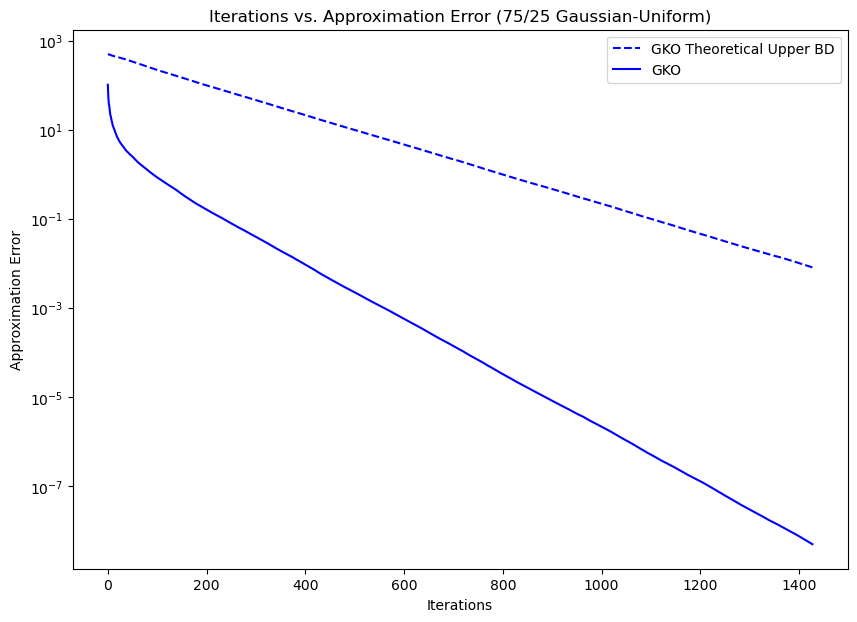

In [74]:
# plot the results with the theoretical upper bound
plt.figure(figsize=(10,7))
# plot theoretical bound
plt.semilogy(np.arange(len(gko_gu2[2])), gko_gu2[2], linestyle = 'dashed', 
             color = "blue", label = 'GKO Theoretical Upper BD')
plt.semilogy(np.arange(gko_gu2[0] - 1), gko_gu2[1], linestyle = 'solid', 
             color = "blue", label = 'GKO')

plt.xlabel('Iterations')
plt.ylabel('Approximation Error')
plt.title('Iterations vs. Approximation Error (75/25 Gaussian-Uniform)')
plt.legend()

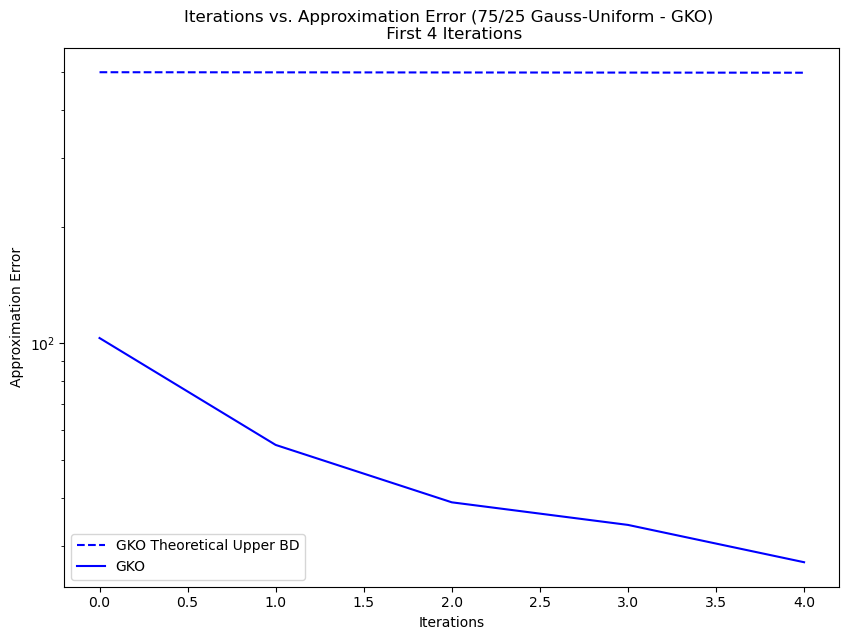

In [75]:
# Show MWRKO empirical and theoretical results
plt.figure(figsize=(10,7))
# plot theoretical bound
plt.semilogy(np.arange(5), mwrko_gu2[2][0:5], linestyle = 'dashed', 
             color = "blue", label = 'GKO Theoretical Upper BD')
# plot empirical results
plt.semilogy(np.arange(5), mwrko_gu2[1][0:5], linestyle = 'solid', 
             color = "blue", label = 'GKO')
# labels
plt.xlabel('Iterations')
plt.ylabel('Approximation Error')
plt.title('Iterations vs. Approximation Error (75/25 Gauss-Uniform - GKO) \n First 4 Iterations')
plt.legend()

In [76]:
# table
k = list(range(1,11))
k.extend(list(range((mwrko_gu2[0]-9), mwrko_gu2[0]+1)))
# empirical result data
e_result = list(mwrko_gu2[1][0:10])
e_result.extend(list(mwrko_gu2[1][-11:-1]))
# theoretical result data
t_result = list(mwrko_gu2[2][0:10])
t_result.extend(list(mwrko_gu2[2][-11:-1]))
# create and print df
mwrko_gu2_df = pd.DataFrame()
mwrko_gu2_df['k'] = k
mwrko_gu2_df['Theoretical BD'] = t_result
mwrko_gu2_df['Empirical Results'] = e_result
mwrko_gu2_df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
k,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000,1.598000e+03,1.599000e+03,1.600000e+03,1.601000e+03,1.602000e+03,1.603000e+03,1.604000e+03,1.605000e+03,1.606000e+03,1.607000e+03
Theoretical BD,499.639574,499.279337,498.919287,498.559496,498.199965,497.840694,497.481681,497.122927,496.764432,496.406196,1.581043e+02,1.579902e+02,1.578763e+02,1.577625e+02,1.576487e+02,1.575350e+02,1.574214e+02,1.573079e+02,1.571944e+02,1.570811e+02
Empirical Results,103.252359,54.768337,38.965904,34.079879,27.313509,22.057193,20.097190,18.185283,16.296822,14.743309,5.644711e-09,5.581511e-09,5.510431e-09,5.437196e-09,5.368703e-09,5.306831e-09,5.244758e-09,5.178086e-09,5.115561e-09,5.046617e-09


## 25/75 Gauss-Uniform System

In [77]:
# setting up data
A1 = np.random.rand(3750,500)
A2 = np.random.randn(1250,500)
A = np.concatenate((A1, A2))
A = normalize(A, axis=1, norm='l2')
x = np.ones(500)
y = A @ x
TOL = 10**-4

In [78]:
# Find the minimum singular value
U,S,V = np.linalg.svd(A)
S2_min = min(S**2)
# Find the max angle
angles_g = compute_sin2(A)
max_angle_g = max(angles_g)
# Find the row norm
row_norm_g = np.sum(np.abs(A)**2,axis=-1)
max_row_norm_g = max(row_norm_g)

In [79]:
# Compute LH of convergence rate
# gk (LH1 = LH2 = 0)
LHk_gk = S2_min / 4
# gko
LH1_gko = 1 - ( S2_min / m )
#LH2_gko = S2_min / (max_angle_g * (m-1)) )
LHk_gko = S2_min / max_angle_g 
# mwrko
LH1_mwrko = 1 - ( S2_min / m )
LH2_mwrko = 1- ( S2_min / (max_angle_g * (m-1)) )
LHk_mwrko =  1- ( S2_min / (max_angle_g * (m-2)) )

In [80]:
# Run algorithms
gk_gu3 = method2(A,x,y,'GK', 0, 0, LHk_gk, 0.5*10**-8)
gko_gu3 = method2(A,x,y,'GKO', LHk_gko, LHk_gko, LHk_gko, 0.5*10**-8)
mwrko_gu3 = method2(A,x,y,'MWRKO', LH1_mwrko, LH2_mwrko, LHk_mwrko,0.5*10**-8)

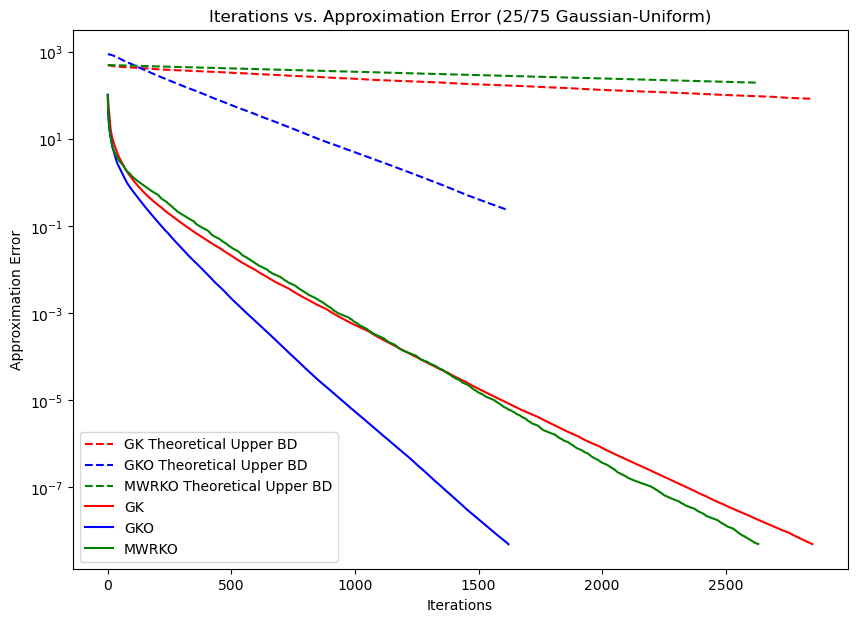

In [81]:
# plot the results with the theoretical upper bound
plt.figure(figsize=(10,7))
# plot theoretical bound
plt.semilogy(np.arange(len(gk_gu3[2])), gk_gu3[2], linestyle = 'dashed',
             color = "red", label = 'GK Theoretical Upper BD')
plt.semilogy(np.arange(len(gko_gu3[2])), gko_gu3[2], linestyle = 'dashed', 
             color = "blue", label = 'GKO Theoretical Upper BD')
plt.semilogy(np.arange(len(mwrko_gu3[2])), mwrko_gu3[2], linestyle = 'dashed', 
             color = "green", label = 'MWRKO Theoretical Upper BD')
# plot empirical results
plt.semilogy(np.arange(gk_gu3[0] - 1), gk_gu3[1], 
             color = "red", linestyle = 'solid', label = 'GK')
plt.semilogy(np.arange(gko_gu3[0] - 1), gko_gu3[1], linestyle = 'solid', 
             color = "blue", label = 'GKO')
plt.semilogy(np.arange(mwrko_gu3[0] - 1), mwrko_gu3[1], linestyle = 'solid', 
             color = "green", label = 'MWRKO')
plt.xlabel('Iterations')
plt.ylabel('Approximation Error')
plt.title('Iterations vs. Approximation Error (25/75 Gaussian-Uniform)')
plt.legend()

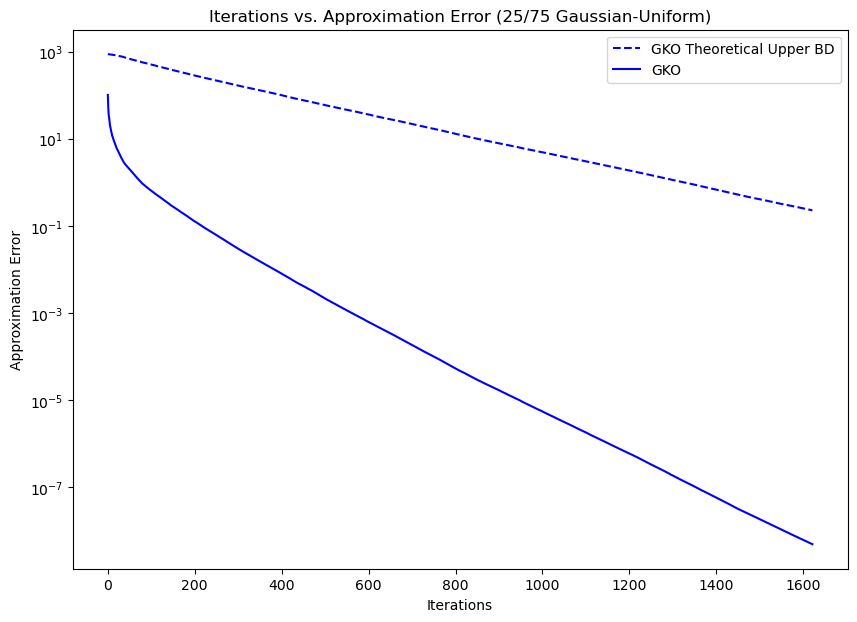

In [82]:
# plot the results with the theoretical upper bound
plt.figure(figsize=(10,7))
# plot theoretical bound
plt.semilogy(np.arange(len(gko_gu3[2])), gko_gu3[2], linestyle = 'dashed', 
             color = "blue", label = 'GKO Theoretical Upper BD')
plt.semilogy(np.arange(gko_gu3[0] - 1), gko_gu3[1], linestyle = 'solid', 
             color = "blue", label = 'GKO')
plt.xlabel('Iterations')
plt.ylabel('Approximation Error')
plt.title('Iterations vs. Approximation Error (25/75 Gaussian-Uniform)')
plt.legend()

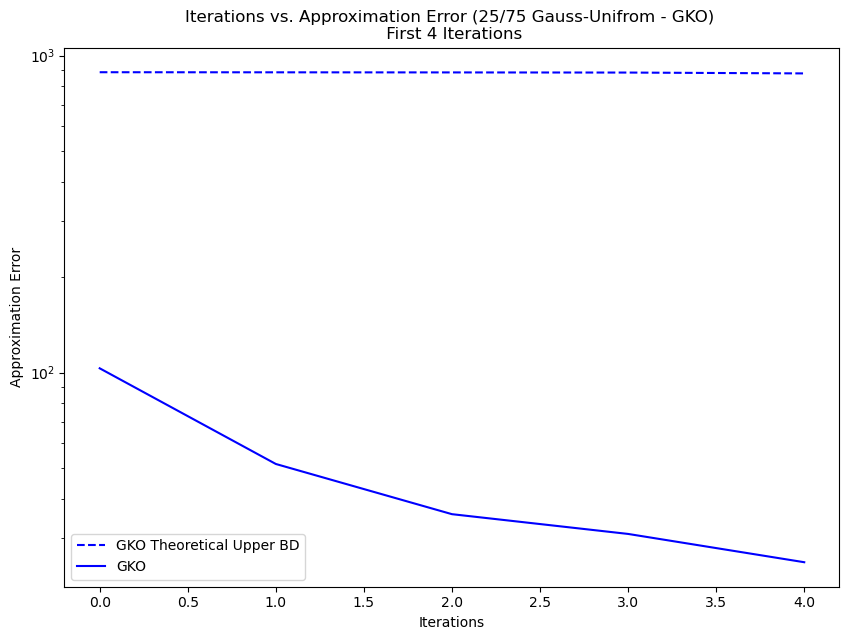

In [83]:
# Show MWRKO empirical and theoretical results
plt.figure(figsize=(10,7))
# plot theoretical bound
plt.semilogy(np.arange(5), gko_gu3[2][0:5], linestyle = 'dashed', 
             color = "blue", label = 'GKO Theoretical Upper BD')
# plot empirical results
plt.semilogy(np.arange(5), gko_gu3[1][0:5], linestyle = 'solid', 
             color = "blue", label = 'GKO')
# labels
plt.xlabel('Iterations')
plt.ylabel('Approximation Error')
plt.title('Iterations vs. Approximation Error (25/75 Gauss-Unifrom - GKO) \n First 4 Iterations')
plt.legend()

In [84]:
# table
k = list(range(1,11))
k.extend(list(range((mwrko_gu3[0]-9), mwrko_gu3[0]+1)))
# empirical result data
e_result = list(mwrko_gu3[1][0:10])
e_result.extend(list(mwrko_gu3[1][-11:-1]))
# theoretical result data
t_result = list(mwrko_gu3[2][0:10])
t_result.extend(list(mwrko_gu3[2][-11:-1]))
# create and print df
mwrko_gu3_df = pd.DataFrame()
mwrko_gu3_df['k'] = k
mwrko_gu3_df['Theoretical BD'] = t_result
mwrko_gu3_df['Empirical Results'] = e_result
mwrko_gu3_df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
k,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000,2.625000e+03,2.626000e+03,2.627000e+03,2.628000e+03,2.629000e+03,2.630000e+03,2.631000e+03,2.632000e+03,2.633000e+03,2.634000e+03
Theoretical BD,499.822768,499.645564,499.468386,499.291272,499.114221,498.937232,498.760306,498.583443,498.406642,498.229904,1.972186e+02,1.971487e+02,1.970787e+02,1.970089e+02,1.969390e+02,1.968692e+02,1.967993e+02,1.967296e+02,1.966598e+02,1.965901e+02
Empirical Results,103.167034,51.493246,35.759972,30.979030,25.225169,20.370502,18.587222,16.411917,14.525790,13.431595,5.238424e-09,5.212957e-09,5.189098e-09,5.165786e-09,5.141659e-09,5.115719e-09,5.090130e-09,5.066313e-09,5.044721e-09,5.022894e-09


## Two Highly Correlated Systems

In [85]:
# setting up data
# Step 1: generate two gaussian linear system
A = np.random.randn(2,500)
A1 = np.reshape(A[0,:], (1, 500))
A2 = np.reshape(A[1,:], (1, 500))
# Step 2: generate correalted systems
U = np.random.uniform(low = 0, high = 1, size  = (2500,500))
A1 =  np.tile(A1, (2500, 1)) +  U
A2 =  np.tile(A2, (2500, 1)) +  U
# Step 3: Combine two correlated systems
A = np.concatenate((A1, A2))
A = normalize(A, axis=1, norm='l2')
x = np.ones(500)
y = A @ x
TOL = 10**-4

In [86]:
# Compute LH of convergence rate
# gk (LH1 = LH2 = 0)
LHk_gk = S2_min / 4
# gko
LH1_gko = 1 - ( S2_min / m )
#LH2_gko = S2_min / (max_angle_g * (m-1)) )
LHk_gko = S2_min / max_angle_g 
# mwrko
LH1_mwrko = 1 - ( S2_min / m )
LH2_mwrko = 1- ( S2_min / (max_angle_g * (m-1)) )
LHk_mwrko =  1- ( S2_min / (max_angle_g * (m-2)) )

In [ ]:
# Run algorithms
gk_corr = method2(A,x,y,'GK', 0, 0, LHk_gk, 0.5*10**-8)
gko_corr = method2(A,x,y,'GKO', LH1_gko, LHk_gko, LHk_gko, 0.5*10**-8)
mwrko_corr = method2(A,x,y,'MWRKO', LH1_mwrko, LH2_mwrko, LHk_mwrko,0.5*10**-8)

In [ ]:
# plot the results with the theoretical upper bound
plt.figure(figsize=(10,7))
# plot theoretical bound
plt.semilogy(np.arange(len(gk_corr[2])), gk_corr[2], linestyle = 'dashed',
             color = "red", label = 'GK Theoretical Upper BD')
plt.semilogy(np.arange(len(gko_corr[2])), gko_corr[2], linestyle = 'dashed', 
             color = "blue", label = 'GKO Theoretical Upper BD')
plt.semilogy(np.arange(len(mwrko_corr[2])), mwrko_corr[2], linestyle = 'dashed', 
             color = "green", label = 'MWRKO Theoretical Upper BD')
# plot empirical results
plt.semilogy(np.arange(gk_corr[0] - 1), gk_corr[1], 
             color = "red", linestyle = 'solid', label = 'GK')
plt.semilogy(np.arange(gko_corr[0] - 1), gko_corr[1], linestyle = 'solid', 
             color = "blue", label = 'GKO')
plt.semilogy(np.arange(mwrko_corr[0] - 1), mwrko_corr[1], linestyle = 'solid', 
             color = "green", label = 'MWRKO')
plt.xlabel('Iterations')
plt.ylabel('Approximation Error')
plt.title('Iterations vs. Approximation Error (Correlated Systems)')
plt.legend()

In [ ]:
# plot the results with the theoretical upper bound
plt.figure(figsize=(10,7))
# plot theoretical bound
plt.semilogy(np.arange(len(gko_corr[2])), gko_corr[2], linestyle = 'dashed', 
             color = "blue", label = 'GKO Theoretical Upper BD')
plt.semilogy(np.arange(gko_corr[0] - 1), gko_corr[1], linestyle = 'solid', 
             color = "blue", label = 'GKO')

plt.xlabel('Iterations')
plt.ylabel('Approximation Error')
plt.title('Iterations vs. Approximation Error (Correlated Systems)')
plt.legend()

In [ ]:
# Show MWRKO empirical and theoretical results
plt.figure(figsize=(10,7))
# plot theoretical bound
plt.semilogy(np.arange(5), gko_corr[2][0:5], linestyle = 'dashed', 
             color = "blue", label = 'GKO Theoretical Upper BD')
# plot empirical results
plt.semilogy(np.arange(5), gko_corr[1][0:5], linestyle = 'solid', 
             color = "blue", label = 'GKO')
# labels
plt.xlabel('Iterations')
plt.ylabel('Approximation Error')
plt.title('Iterations vs. Approximation Error (Correlated Systems - GKO) \n First 4 Iterations')
plt.legend()

In [ ]:
# table
k = list(range(1,11))
k.extend(list(range((mwrko_corr[0]-9), mwrko_corr[0]+1)))
# empirical result data
e_result = list(mwrko_corr[1][0:10])
e_result.extend(list(mwrko_corr[1][-11:-1]))
# theoretical result data
t_result = list(mwrko_corr[2][0:10])
t_result.extend(list(mwrko_corr[2][-11:-1]))
# create and print df
mwrko_corr_df = pd.DataFrame()
mwrko_corr_df['k'] = k
mwrko_corr_df['Theoretical BD'] = t_result
mwrko_corr_df['Empirical Results'] = e_result
mwrko_corr_df.T